In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout
from tensorflow.keras.activations import relu, linear, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

import lightgbm as lgb
from lightgbm import LGBMRegressor

import json

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.inspection import permutation_importance

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

import xgboost as xgb 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import yellowbrick.model_selection as ms

In [29]:
csv_training_files = ['../Datasets/landsat_features_more_bands_train.csv',
                          '../Datasets/terraclimate_features_more_bands_training.csv',
                          '../Datasets/nasa_precip_features_training.csv',
                          '../Datasets/soil_use_data_rounded_in_packs_training.csv',
                          '../Datasets/nasa_terrain_features_rounded_in_packs_training.csv',
                          '../Datasets/water_quality_training_dataset.csv']

target_columns = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']


#pegando features Boost_model
with open('../Signal_Features/best_features_XGBoost.json', 'r') as f:
    best_features_rf = json.load(f)


drop_features = {target: best_features_rf[target] for target in target_columns }

# este é um dataHandler geral, os outros são especificos pros targets
dataHandler = DataOrganizer(target_columns)
dataHandler.load_training_data(csv_training_files, [], scale=True)

metadata = ["Latitude", "Longitude", "Sample Date"]

columns_to_drop_from_features_alkalinity = list( set(dataHandler.get_feature_columns()) - set(drop_features["Total Alkalinity"]) ) + metadata
columns_to_drop_from_features_eelctrical = list( set(dataHandler.get_feature_columns()) - set(drop_features["Electrical Conductance"]) ) + metadata
columns_to_drop_from_features_phosphorus = list(set(dataHandler.get_feature_columns()) - set(drop_features["Dissolved Reactive Phosphorus"])) + metadata

dataHandler_alkalinity = DataOrganizer(target_columns)
dataHandler_electrical = DataOrganizer(target_columns)
dataHandler_phosphorus = DataOrganizer(target_columns)

dataHandler_alkalinity.load_training_data(csv_training_files, columns_to_drop_from_features_alkalinity, scale=True)
dataHandler_electrical.load_training_data(csv_training_files, columns_to_drop_from_features_eelctrical, scale=True)
dataHandler_phosphorus.load_training_data(csv_training_files, columns_to_drop_from_features_phosphorus, scale=True)




In [30]:


train_splits_alkalinity = get_location_train_test_split(dataHandler_alkalinity, test_size = 0.2)
train_splits_electrical = get_location_train_test_split(dataHandler_electrical, test_size = 0.2)
train_splits_phosphorus = get_location_train_test_split(dataHandler_phosphorus, test_size = 0.2)

X_train_alkalinity = train_splits_alkalinity['Total Alkalinity']['X_train']
X_test_alkalinity = train_splits_alkalinity['Total Alkalinity']['X_test']
Y_train_alkalinity = train_splits_alkalinity['Total Alkalinity']['Y_train']
Y_test_alkalinity = train_splits_alkalinity['Total Alkalinity']['Y_test']

X_train_electrical = train_splits_electrical['Electrical Conductance']['X_train']
X_test_electrical = train_splits_electrical['Electrical Conductance']['X_test']
Y_train_electrical = train_splits_electrical['Electrical Conductance']['Y_train']
Y_test_electrical = train_splits_electrical['Electrical Conductance']['Y_test']

X_train_phosphorus = train_splits_phosphorus['Dissolved Reactive Phosphorus']['X_train']
X_test_phosphorus = train_splits_phosphorus['Dissolved Reactive Phosphorus']['X_test']
Y_train_phosphorus = train_splits_phosphorus['Dissolved Reactive Phosphorus']['Y_train']
Y_test_phosphorus = train_splits_phosphorus['Dissolved Reactive Phosphorus']['Y_test']

X_train_alkalinity



✅ Split concluído: 7395 amostras para treino, 1924 para teste.
✅ Split concluído: 7395 amostras para treino, 1924 para teste.
✅ Split concluído: 7395 amostras para treino, 1924 para teste.


,green,swir22,q,ppt,pet,rain_7d_nasa,rain_3d_nasa,pct_agri,pct_water,pct_wetlands
0,0.289543,-1.395962,-0.340357,-0.677301,-0.032784,-0.590218,-0.458178,-0.800066,3.745750,-0.070432
1,-0.193153,-0.366148,-0.213983,-0.345761,-1.732917,2.988845,2.286193,1.574208,-0.266969,-0.070432
2,0.107889,0.909078,-0.150797,-0.136747,-1.617538,2.253988,1.984634,0.980639,-0.266969,-0.070432
3,1.880561,2.468742,-0.011786,0.250649,-1.542882,2.533441,2.522476,-0.800066,-0.266969,-0.070432
4,-0.205374,-0.693480,-0.049698,0.138935,-1.559849,2.533441,2.522476,0.980639,-0.266969,-0.070432
...,...,...,...,...,...,...,...,...,...,...
9312,-0.142464,-0.591870,-0.378269,-0.807034,1.182082,0.222264,0.928258,-0.800066,3.745750,-0.070432
9313,-0.141564,0.548696,-0.251895,-0.423241,0.567862,-0.224343,-0.085826,-0.800066,-0.266969,-0.070432
9315,-0.001592,1.088038,-0.315082,-0.621444,0.245482,0.669906,1.421050,1.574208,-0.266969,-0.070432
9317,0.193056,1.444729,-0.466730,-1.034066,1.616447,-0.536915,-0.404854,0.387071,-0.266969,-0.070432


## XGBoost

In [31]:
model_params = {
    'objective' :'reg:squarederror',
    'booster':'dart',
    'learning_rate' : 0.05, # bom
    'max_depth' : 5, # bom, muda comforme adicionar dados 
    'n_estimators' : 40, # bom, muda conforme adicionar dados
    'subsample' : 0.5,
    'colsample_bytree' : 0.6,
    'min_child_weight' : 25.0, ## fixado assim, bom
    'gamma' : 1.5,  ## fixado assim, bom
    'verbosity' : 1,
    'rate_drop' : 0.25, # bom : 0.25
    'skip_drop' : 0.5, # bom : 0.5
    
    'reg_lambda' : 20.0,                # L2 >= 0
    'reg_alpha' : 12.0,
}

model_alkalinity= xgb.XGBRegressor(**model_params)

model_electrical= xgb.XGBRegressor(**model_params)


model_phosphorus= xgb.XGBRegressor(**model_params)

# parametros treino:


In [32]:

model_alkalinity.fit(X_train_alkalinity, Y_train_alkalinity,
            eval_set=[(X_test_alkalinity, Y_test_alkalinity)])

model_electrical.fit(X_train_electrical, Y_train_electrical,
            eval_set=[(X_test_electrical, Y_test_electrical)])

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus,
            eval_set=[(X_test_phosphorus, Y_test_phosphorus)])

[0]	validation_0-rmse:72.55971
[1]	validation_0-rmse:71.65370
[2]	validation_0-rmse:71.11183
[3]	validation_0-rmse:70.21976
[4]	validation_0-rmse:69.26832
[5]	validation_0-rmse:68.82796


[6]	validation_0-rmse:68.40608
[7]	validation_0-rmse:68.11303
[8]	validation_0-rmse:67.81123
[9]	validation_0-rmse:67.17430
[10]	validation_0-rmse:66.55530
[11]	validation_0-rmse:66.27551
[12]	validation_0-rmse:65.94025
[13]	validation_0-rmse:65.45553
[14]	validation_0-rmse:64.97878
[15]	validation_0-rmse:64.59895
[16]	validation_0-rmse:64.14178
[17]	validation_0-rmse:63.97733
[18]	validation_0-rmse:63.88031
[19]	validation_0-rmse:63.84036
[20]	validation_0-rmse:63.66980
[21]	validation_0-rmse:63.65698
[22]	validation_0-rmse:63.64014
[23]	validation_0-rmse:63.63036
[24]	validation_0-rmse:63.56432
[25]	validation_0-rmse:63.09808
[26]	validation_0-rmse:63.08078
[27]	validation_0-rmse:63.07216
[28]	validation_0-rmse:62.80160
[29]	validation_0-rmse:62.76689
[30]	validation_0-rmse:62.34967
[31]	validation_0-rmse:62.31612
[32]	validation_0-rmse:62.25924
[33]	validation_0-rmse:62.22628
[34]	validation_0-rmse:61.90507
[35]	validation_0-rmse:61.67527
[36]	validation_0-rmse:61.67431
[37]	validat

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,'dart'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.6
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

## LGBM

In [4]:
model_params = {
    'boosting_type':'gbdt',       # 'gbdt' (tradicional) ou 'dart'
    'n_estimators':250,           # Mais árvores, pois o LGBM é rápido
    'learning_rate':0.03,         # Passo menor para melhor generalização
    'num_leaves':23,              # O mais importante do LGBM (Controle de complexidade) - manter entre 20 e 40
    'max_depth':-1,                # Limita a profundidade para evitar decorar o mapa
    'min_child_samples':20,       # Equivalente ao min_child_weight (evita folhas com poucos dados), overfitting e under
    'min_child_weight': 0.1,     # Evita folhas com poucos dados, overfitting e underfitting
    'subsample':0.7,              # % de dados por árvore
    'colsample_bytree':0.5,       # % de features por árvore (fundamental para o seu caso)
    'reg_alpha':10.0,             # Regularização L1
    'reg_lambda':10.0,            # Regularização L2
    'random_state':42,
    'n_jobs':-1,                  # Usa todos os núcleos do processador
    'importance_type':'gain',      # Mede importância pelo ganho de precisão
    'verbosity': -1,
    
    #boosting_type='dart',
    #drop_rate=0.15,             # % de árvores a dropar
    #skip_drop=0.5,              # Probabilidade de pular o drop
}

model_alcalinity= LGBMRegressor(**model_params)

model_electrical= LGBMRegressor(**model_params)

model_phosphorus= LGBMRegressor(**model_params)

In [5]:
model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity,
            eval_set=[(X_test_alkalinity, Y_test_alkalinity)])

model_electrical.fit(X_train_electrical, Y_train_electrical,
            eval_set=[(X_test_electrical, Y_test_electrical)])

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus,
            eval_set=[(X_test_phosphorus, Y_test_phosphorus)])

,boosting_type,'gbdt'
,num_leaves,23
,max_depth,-1
,learning_rate,0.03
,n_estimators,250
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.1
,min_child_samples,20


## Random Forest

In [16]:
params = {
    'n_estimators':220,           # [100-500] Núm. de árvores. Mais é melhor, mas pesa no PC.
    'max_depth':7,                # [4-10] Profundidade. Mantenha baixo para evitar decorar o mapa.
#    'min_samples_leaf':10,        # [5-50] Mín. de amostras por folha. Ótimo contra overfitting.
    'max_features':0.5,        # ['sqrt', 'log2', 0.5] Quantas colunas cada árvore vê. 
#                                # 'sqrt' força o modelo a não depender só de Tmax/Relevo.
    'bootstrap':True,             # Usa amostras aleatórias dos dados.
    'n_jobs':-1,                  # Usa todos os núcleos do seu processador (muito rápido).
#    'random_state':42,
#    'verbose':0
}

model_alcalinity= RandomForestRegressor(**params)
    
model_electrical= RandomForestRegressor(**params)

model_phosphorus= RandomForestRegressor(**params)


In [17]:
model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity)

model_electrical.fit(X_train_electrical, Y_train_electrical)

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",220
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",7
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",0.5
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

## Rede Neural

In [585]:
model_alcalinity = Sequential([
    tf.keras.Input(shape=(X_train_electrical.shape[1],)),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dense(1, activation="relu")
])

model_electrical = Sequential([
    tf.keras.Input(shape=(X_train_electrical.shape[1],)),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dense(1, activation="relu")
])

model_phosphorus = Sequential([
    tf.keras.Input(shape=(X_train_phosphorus.shape[1],)),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dense(1, activation="relu")
])

model_alcalinity.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model_electrical.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model_phosphorus.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [586]:
model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity, validation_data=(X_test_alkalinity, Y_test_alkalinity), epochs=30, batch_size=32)
    
model_electrical.fit(X_train_electrical, Y_train_electrical, validation_data=(X_test_electrical, Y_test_electrical), epochs=30, batch_size=32)

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus, validation_data=(X_test_phosphorus, Y_test_phosphorus), epochs=30, batch_size=32)

Epoch 1/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7204.8535 - val_loss: 4111.7739
Epoch 2/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3872.7002 - val_loss: 3938.9475
Epoch 3/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3673.9021 - val_loss: 4165.9595
Epoch 4/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3569.9626 - val_loss: 4257.6182
Epoch 5/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3610.1836 - val_loss: 4074.8533
Epoch 6/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3488.0557 - val_loss: 3934.0332
Epoch 7/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3435.8362 - val_loss: 4107.4829
Epoch 8/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3393.4565 - val_loss: 4197.2100
Epoch 9/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3408.5586 - val_loss: 4241.5171
Epoch 10/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3358.6294 - val_loss: 4215.0415
Epoch 11/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3278.7522 - val_lo

## Selecao de Features

### Colocar dados com um dataHandler geral ( com todas as features ) ai classe decide quais sao as mais importantes para cada target

In [27]:
classifier = FeatureClassifier(csv_training_files=csv_training_files)

classifier.define_model(model_alkalinity)

best_features_dict = classifier.classify_features_per_target(feature_to_start='swir22', penalty_weight=0.3)

print(best_features_dict)

with open('../Signal_Features/best_features_XGBoost.json', 'w', encoding= 'utf-8') as f:
    json.dump(best_features_dict, f, indent=4)


📥 Carregando todos os dados para memória...
✅ Split concluído: 7395 amostras para treino, 1924 para teste.

🎯 Seleção para Total Alkalinity (Penalidade: 0.3)
   🔹 Base Score: 0.0096 (R2 Test: 0.026 | Gap: 0.055)


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


🏁 Finalizado para Total Alkalinity
   Features: 10
   Melhor Score Penalizado: 0.2268
   R² Teste Final: 0.2557
   Lista: ['swir22', 'green', 'q', 'ppt', 'pet', 'rain_7d_nasa', 'rain_3d_nasa', 'pct_agri', 'pct_water', 'pct_wetlands']

🎯 Seleção para Electrical Conductance (Penalidade: 0.3)
   🔹 Base Score: -0.0170 (R2 Test: -0.001 | Gap: 0.052)


100%|██████████| 36/36 [00:05<00:00,  6.68it/s]


🏁 Finalizado para Electrical Conductance
   Features: 13
   Melhor Score Penalizado: 0.2158
   R² Teste Final: 0.2751
   Lista: ['swir22', 'green', 'blue', 'red', 'q', 'pet', 'pdsi', 'tmin', 'Runoff_Ratio', 'rain_7d_nasa', 'pct_agri', 'pct_natural', 'elevation']

🎯 Seleção para Dissolved Reactive Phosphorus (Penalidade: 0.3)
   🔹 Base Score: -0.0849 (R2 Test: -0.054 | Gap: 0.104)


100%|██████████| 36/36 [00:05<00:00,  6.64it/s]

🏁 Finalizado para Dissolved Reactive Phosphorus
   Features: 13
   Melhor Score Penalizado: 0.1342
   R² Teste Final: 0.1694
   Lista: ['swir22', 'green', 'swir16', 'Clorfilia', 'NDTI', 'NDVI', 'q', 'ppt', 'pet', 'pdsi', 'Saline_Index', 'slope', 'curvature']
{'Total Alkalinity': ['swir22', 'green', 'q', 'ppt', 'pet', 'rain_7d_nasa', 'rain_3d_nasa', 'pct_agri', 'pct_water', 'pct_wetlands'], 'Electrical Conductance': ['swir22', 'green', 'blue', 'red', 'q', 'pet', 'pdsi', 'tmin', 'Runoff_Ratio', 'rain_7d_nasa', 'pct_agri', 'pct_natural', 'elevation'], 'Dissolved Reactive Phosphorus': ['swir22', 'green', 'swir16', 'Clorfilia', 'NDTI', 'NDVI', 'q', 'ppt', 'pet', 'pdsi', 'Saline_Index', 'slope', 'curvature']}


## training

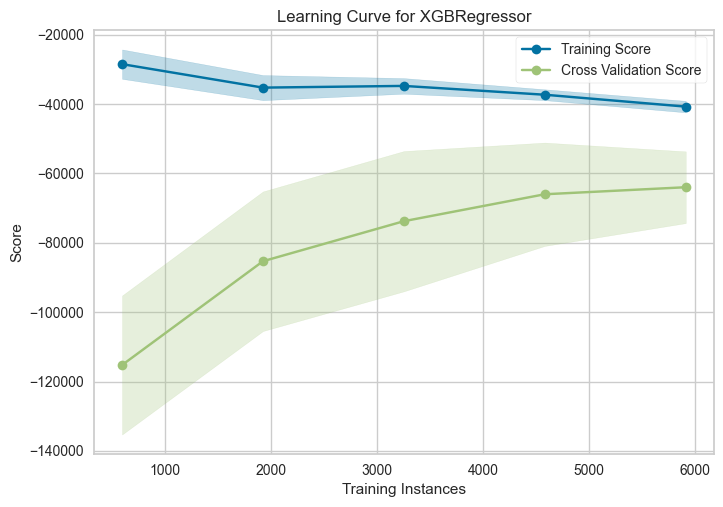

In [37]:
_ = ms.learning_curve(model_electrical, X_train_electrical, Y_train_electrical, scoring='neg_mean_squared_error', cv=5)

<Axes: >

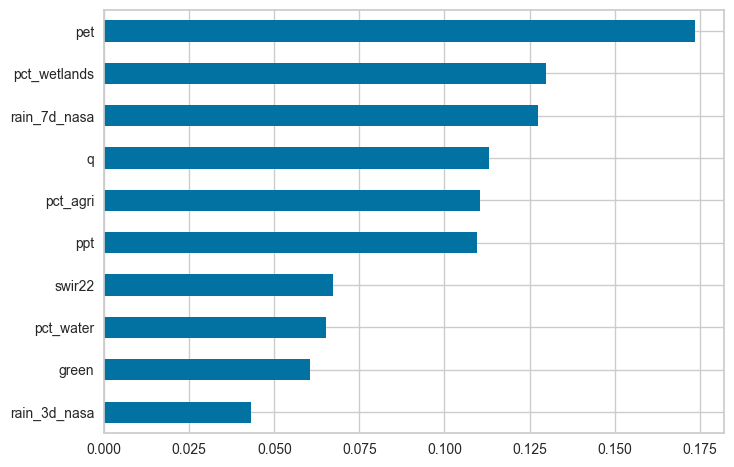

In [33]:
(pd.Series(model_alkalinity.feature_importances_, index = X_train_alkalinity.columns).sort_values().plot.barh())


<Axes: >

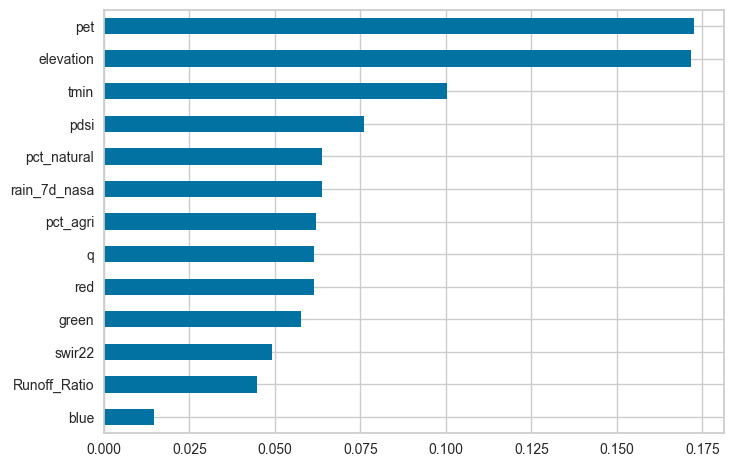

In [34]:

(pd.Series(model_electrical.feature_importances_, index = X_train_electrical.columns).sort_values().plot.barh())


<Axes: >

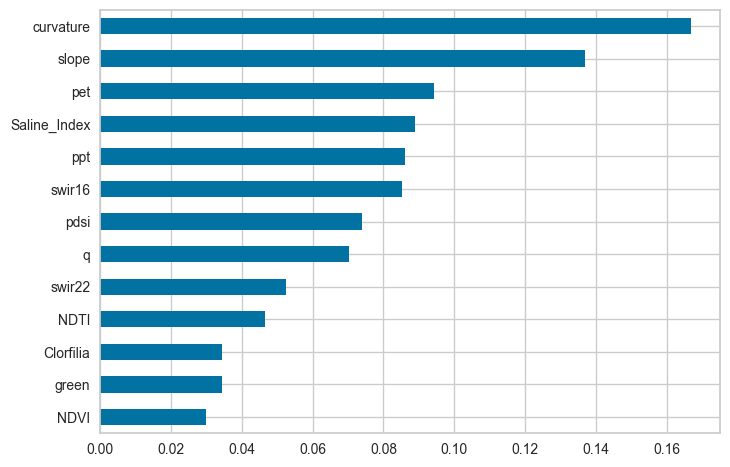

In [35]:

(pd.Series(model_phosphorus.feature_importances_, index = X_train_phosphorus.columns).sort_values().plot.barh())

In [36]:
#make the print in green
print("\033[92mavaliando fosforo\033[0m")
evaluate_model(model_phosphorus.predict(X_train_phosphorus), Y_train_phosphorus, "train evaluation", verbose = True)
evaluate_model(model_phosphorus.predict(X_test_phosphorus), Y_test_phosphorus, "test evaluation", verbose = True)

print()
print("\033[92mavaliando alcalinidade\033[0m")
evaluate_model(model_alkalinity.predict(X_train_alkalinity), Y_train_alkalinity, "train evaluation", verbose = True)
evaluate_model(model_alkalinity.predict(X_test_alkalinity), Y_test_alkalinity, "test evaluation", verbose = True)

print()
print("\033[92mavaliando condutividade eletrica\033[0m")
evaluate_model(model_electrical.predict(X_train_electrical), Y_train_electrical, "train evaluation", verbose = True)
evaluate_model(model_electrical.predict(X_test_electrical), Y_test_electrical, "test evaluation", verbose = True)

avaliando fosforo

train evaluation Evaluation:
R²: 0.288
RMSE: 41.301

test evaluation Evaluation:
R²: 0.164
RMSE: 52.147

avaliando alcalinidade

train evaluation Evaluation:
R²: 0.353
RMSE: 60.471

test evaluation Evaluation:
R²: 0.256
RMSE: 61.315

avaliando condutividade eletrica

train evaluation Evaluation:
R²: 0.470
RMSE: 252.460

test evaluation Evaluation:
R²: 0.278
RMSE: 272.123


(array([300.4543 , 353.66946, 356.5051 , ..., 735.32544, 371.7774 ,
        754.47144], dtype=float32),
 0.2776088482847192,
 np.float64(272.1225378354759))

## Submission

In [37]:
submission_csv_files = ['../Datasets/landsat_features_more_bands_validation.csv',
                          '../Datasets/terraclimate_features_more_bands_validation.csv',
                          '../Datasets/nasa_precip_features_validation.csv',
                          '../Datasets/soil_use_data_validation.csv',
                          '../Datasets/nasa_terrain_features_validation.csv'
]


dataHandler_alkalinity.load_submission_data(submission_csv_files)
dataHandler_electrical.load_submission_data(submission_csv_files)
dataHandler_phosphorus.load_submission_data(submission_csv_files)


alkalinity_submission_data = dataHandler_alkalinity.get_submission_dataset()
electrical_submission_data = dataHandler_electrical.get_submission_dataset()
phosphorus_submission_data = dataHandler_phosphorus.get_submission_dataset()


In [38]:


X_pred_input_features_alkalinity = alkalinity_submission_data
X_pred_input_features_electrical = electrical_submission_data
X_pred_input_features_phosphorus = phosphorus_submission_data


y_submission_pred_alkalinity = model_alkalinity.predict(X_pred_input_features_alkalinity)
y_submission_pred_electrical = model_electrical.predict(X_pred_input_features_electrical)
y_submission_pred_phosphorus = model_phosphorus.predict(X_pred_input_features_phosphorus)

predicted_values_dict = {
    'Total Alkalinity': y_submission_pred_alkalinity, 
    'Electrical Conductance': y_submission_pred_electrical, 
    'Dissolved Reactive Phosphorus': y_submission_pred_phosphorus
}


predicted_pd_final = dataHandler_alkalinity.build_get_submission_dataset(predicted_values_dict)

predicted_pd_final.to_csv("../Results/submission_predictions_boosted_more_data.csv", index=False)


## Averiguando Importância das Features ( sinal ou lixo )